FINAL DRAFT OF THIS 
Inputs: cdom files 
outputs: wavelenths.csv, plot.png, outputs.csv
    
    the only cells that need edits are at the top 
    they are labled "with edit here"
    
    Hanna Bridgham 
    6/6/2022


In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [41]:
#EDIT HERE
####################################
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117/*.txt')
# You should add the path of your outputs 
path_1 = '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_ABS_HALO_2117_Pchip_wavelenths.csv'
path_2 = '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_ABS_HALO_2117.png'
path_3 = '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_ABS_HALO_2117_outputs.csv'

files

['../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211731_Absorbance_01.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211731_Absorbance_02.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211731_Absorbance_03.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211732_Absorbance_01.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211732_Absorbance_02.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211732_Absorbance_03.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211733_Absorbance_01.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211733_Absorbance_02.txt',
 '../../../OOC_Conferace_data/PW_CDOM_HALO/PW_Abs_HALO21_ID2117\\PWP2F_Abs_HALO21_ID211733_Absorbance_03.txt',
 

In [42]:
#EDIT HERE
####################################
#first Identify what wavegide was used then uncomment the correct waveguide 
#WG 50 #1 : 190987 : 48.9
#WG 50 #2 : 190991 : 48.75
#WG 50 #3 : 192856 : 48.8 

#WG 10 CM 182380 

X = .01

#X = .489 # 50 cm lwcc number 1 SN: , Basiclly antything from GOM2021 thats not PW
#X = .4875 # 50 cm lwcc number 2 SN: , Basiclly antything from GOM21FA thats not PW
#X = .488 # 50 cm lwcc number 3 SN: , Basiclly antything from GOM22SP thats not PW


PART 1: GRAPHS AND WAVELENGTHS 

we use pchip to process the data to get the wavelenths in whole numbers 

we will save this to a output tabel 

we will also save the baseline correction 

In [43]:
#FINAL FUNTION 
#see above for the breakdown of diff parts 
def GET_CDOM_DATA(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    #bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    #df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [44]:
#EDIT HERE
n = 5 # how many underscore breaks 
stri = 3 # the selected underscore break 
split = 1 #spit in the file name string 

####################################
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
#edit the slpit function to get the abs names 
frames = []
for f in files:
    df = GET_CDOM_DATA(f) # runs the processing function 
    ID = f.split("\\")[split] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=n).str[stri]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

,ID211731,ID211732,ID211733,ID211734,ID211736,ID211737,ID211738,ID211739,ID211741,ID211742,ID211743,ID211744,ID211745,ID211746,blank
wl,,,,,,,,,,,,,,,
189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.735982
877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.970224
878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.760696


In [45]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'
bcorr = df[411:412].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df = df[:] - df[411:412].mean(axis=0) # here we correct the data by that average 
df 

,ID211731,ID211732,ID211733,ID211734,ID211736,ID211737,ID211738,ID211739,ID211741,ID211742,ID211743,ID211744,ID211745,ID211746,blank
wl,,,,,,,,,,,,,,,
189,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,-1.785889
190,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,-1.785889
191,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,-1.785889
192,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,-1.785889
193,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,-1.785889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,11.950093
877,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,12.184336
878,-5.51241,-4.480151,-4.250491,-6.332855,-6.302698,-7.317929,-4.965686,-9.433288,-3.433645,-3.349803,-3.96297,-7.746326,-5.351463,-4.599901,8.974807


In [46]:
#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
Abs_data = df.transpose(copy=False)
Abs_data['bcorr'] = bcorr
Abs_data

#save it as a CSV to the propor location with the correct file name
Abs_data.to_csv(path_1)

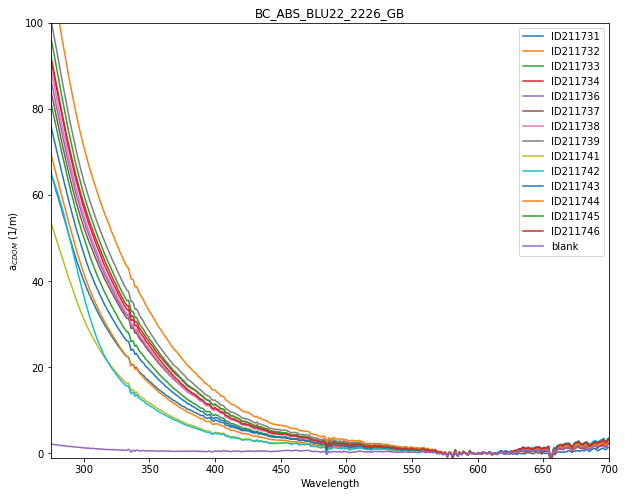

In [47]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 

fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-1,100)
ax.set_xlim(275,700)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")

plt.savefig(path_2)

PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$

corresponding parameters = abs 254, abs 280, abs 320, abs 412, abs 444 

corresponding parameters = the spectral slope of 275 to 295, the spectral slope of 350 to 400, the spectral slope of 275 to 700

corresponding parameters = spectral ratio of spectral slope of 275 to 295 and the spectral slope of 350 to 400

corresponding parameters = baseline correction we used, so the b term 


In [48]:
#OPEN OUR FILES AND MAKE ABSORBANCE TO ABSORPTION
def open_file_abs_base_cor(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [49]:
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = open_file_abs_base_cor(f) # runs the processing function 
    ID = f.split("\\")[split] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=n).str[stri]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = df.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,ID211731,ID211732,ID211733,ID211734,ID211736,ID211737,ID211738,ID211739,ID211741,ID211742,ID211743,ID211744,ID211745,ID211746,blank,wl
wl,,,,,,,,,,,,,,,,
189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,189
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,190
191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,191
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,192
193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.735982,876
877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.970224,877
878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.760696,878


In [50]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [51]:
#HERE DO THE WHOLE EXPO AS A LOOP FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_SEM':[ss_275_700],
        'ss_275_295_SEM':[ss_275_295],
        'ss_350_400_SEM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_SEM':[sr],
        'abs_254_SEM':[abs_254], 
        'abs_280_SEM':[abs_280],
        'abs_320_SEM':[abs_320], 
        'abs_350_SEM':[abs_350],
        'abs_412_SEM':[abs_412], 
        'abs_440_SEM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

ss_outs

,ss_275_700_SEM,ss_275_295_SEM,ss_350_400_SEM,R2_275_700,R2_275_295,R2_350_400,SR_SEM,abs_254_SEM,abs_280_SEM,abs_320_SEM,abs_350_SEM,abs_412_SEM,abs_440_SEM
sample,,,,,,,,,,,,,
ID211731,0.018175,0.001613,0.019169,0.998502,0.999947,0.998919,0.084126,102.984198,64.291704,34.161763,22.314074,11.268716,9.156792
ID211732,0.019757,0.005557,0.019527,0.998813,0.999961,0.999230,0.284583,113.518163,67.431053,33.353232,20.696568,9.646154,7.692998
ID211733,0.018437,0.011599,0.018472,0.998940,0.999931,0.999353,0.627896,127.076835,77.765141,39.693791,24.863911,11.188048,8.606835
ID211734,0.017085,0.014619,0.017496,0.999222,0.999918,0.999511,0.835566,140.529473,89.626438,48.544668,31.743749,15.350861,12.043100
ID211736,0.017423,0.012393,0.018260,0.998913,0.999890,0.999413,0.678699,133.523617,84.622486,45.591824,29.822662,14.652553,11.642088
ID211737,0.017215,0.014064,0.018545,0.998794,0.999872,0.999337,0.758370,129.760963,83.141639,45.676658,30.426057,15.626271,12.658948
ID211738,0.017818,0.014544,0.018841,0.998776,0.999892,0.999445,0.771928,137.189017,85.478026,44.735634,28.507155,13.150434,10.161748
ID211739,0.017181,0.010978,0.017232,0.999070,0.999875,0.999602,0.637111,156.793776,100.738718,55.640433,37.260087,19.397621,15.810222
ID211741,0.021454,0.004414,0.019085,0.996323,0.999937,0.998775,0.231285,90.831040,51.793749,24.483064,14.943733,7.176178,5.915128


In [52]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")
    
ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_SEM'] = np.nan
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_SEM = ss_outs['ss_275_700_SEM']
ss_275_295_SEM = ss_outs['ss_275_295_SEM']
ss_350_400_SEM = ss_outs['ss_350_400_SEM']
abs_254_SEM = ss_outs['abs_254_SEM']
abs_280_SEM = ss_outs['abs_280_SEM']
abs_320_SEM = ss_outs['abs_320_SEM']
abs_412_SEM = ss_outs['abs_412_SEM']
abs_440_SEM = ss_outs['abs_440_SEM']
SR_SEM = ss_outs['SR_SEM']

!!! WARNING !!! 275_700 has a bad R2 !!!
!!! WARNING !!! 350_400 has a bad R2 !!!


In [53]:
#HYPERBOLIC REGRESSION A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

In [54]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_HM':[ss_275_700],
        'ss_275_295_HM':[ss_275_295],
        'ss_350_400_HM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_HM':[sr],
        'abs_254_HM':[abs_254], 
        'abs_280_HM':[abs_280],
        'abs_320_HM':[abs_320], 
        'abs_350_HM':[abs_350],
        'abs_412_HM':[abs_412], 
        'abs_440_HM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

In [55]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_HM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_HM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_HM'] = np.nan
    
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_HM = ss_outs['ss_275_700_HM']
ss_275_295_HM = ss_outs['ss_275_295_HM']
ss_350_400_HM = ss_outs['ss_350_400_HM']
abs_254_HM = ss_outs['abs_254_HM']
abs_280_HM = ss_outs['abs_280_HM']
abs_320_HM = ss_outs['abs_320_HM']
abs_412_HM = ss_outs['abs_412_HM']
abs_440_HM = ss_outs['abs_440_HM']
SR_HM = ss_outs['SR_HM']

!!! WARNING !!! 275_700 has a bad R2 !!!
!!! WARNING !!! 350_400 has a bad R2 !!!


PART 3: MAKE ESTIMATE OF INFLECTION 

So at a lot of these there is an infection at around 350 nm 

We need a way to estimate that inflection 

we are going to look for inflections between 300 and 400 nm and quantify them 


In [56]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [57]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df[(df['wl']>=300) & (df['wl']<=400)][col]
    xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][col]
    ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
    xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we normalize the data 
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
    #here we flaten the data
    y1 = xdata[0]
    y2 = xdata[273]
    x1 = diffs[0]
    x2 = diffs[273]
    m = (x2 - x1)/(y2 - y1)
    mx = m * y1
    b = x1 - mx
    
    diffs = diffs - ((m*xdata)+b)
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #plt.plot(xdata, diffs, 'ko', label='data')
    #plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
    #plt.show()
    #print('The offset of the gaussian baseline is', gaus_baseline)
    #print('The center of the gaussian fit is', center_gaus)
    #print('The sigma of the gaussian fit is', sigma)
    #print('The maximum intensity of the gaussian fit is', H + A)
    #print('The Amplitude of the gaussian fit is', A)
    #print('The FWHM of the gaussian fit is', FWHM)
    
    #here we define some columns for a new data frame with the sample, the R2, and the diffs intigral 
    dict = {'sample':[columnName],
        '350_intergration':[inter],
        'R2':[rSquared]}
    diff = pd.DataFrame(dict)
    
    #here we set the index and append the data together 
    diffs = diff.set_index('sample', drop=True)
    Frames.append(diffs) # adds the new col from each scan to a part of frames 
    
    
diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


IndexError: index 273 is out of bounds for axis 0 with size 101

In [58]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

ValueError: No objects to concatenate

In [59]:
#NOW WE SAVE ALL THE VALUSE WE WANTED TO A TABEL 
outputs = pd.concat([ss_275_700_SEM, ss_275_295_SEM, ss_350_400_SEM,
                    ss_275_700_HM, ss_275_295_HM, ss_350_400_HM,
                    abs_254_SEM, abs_280_SEM, abs_320_SEM, abs_412_SEM, abs_440_SEM,
                    abs_254_HM, abs_280_HM, abs_320_HM, abs_412_HM, abs_440_HM,
                    SR_SEM, SR_HM], axis=1)
#outputs = outputs.rename(columns={0: 'baseline_correction', 1: 'abs_254',
#                                  2: 'abs_280', 3: 'abs_320', 4: 'abs_412', 5: 'abs_444'})
#outputs['350_intergration'] = diffs['350_intergration']
outputs 
#SAVE IT 
outputs.to_csv(path_3)